In [1]:
import pickle
from build_netmob_data import load_subway_shp,load_netmob_gdf,get_information_from_path
import torch
import pandas as pd
import os 
import sys
import glob
import numpy as np
# Obtenir le chemin du dossier parent
current_path = notebook_dir = os.getcwd()
# current_path = os.path.dirname()
working_dir = os.path.abspath(os.path.join(current_path, '..'))

# Ajouter le dossier parent au chemin de recherche des modules
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)
    
from K_fold_validation.K_fold_validation import KFoldSplitter
from utils.utilities_DL import match_period_coverage_with_netmob
from constants.config import get_args
from constants.paths import FILE_NAME,FOLDER_PATH


# ==== GET PARAMETERS ====
model_name ='STGCN' #'MTGNN' # 'STGCN'  #'CNN' # 
dataset_names = ['subway_in','netmob']
args = get_args(model_name,dataset_names)
args.W = 0
args.K_fold = 6   # Means we will use the first fold for the Ray Tuning and the 4 other ones to get the metrics
args.ray = False


coverage = match_period_coverage_with_netmob(FILE_NAME,dataset_names)

args.vision_input_type = 'unique_image_through_lyon' # 'image_per_stations' # 'unique_image_through_lyon'
vision_model_name = 'AttentionFeatureExtractor'  # 'ImageAvgPooling'  # 'FeatureExtractor_ResNetInspired_bis'  #'FeatureExtractor_ResNetInspired' #'MinimalFeatureExtractor',


## Define fixed Dataset K_fold split for each trial: 
folds = np.arange(1)
K_fold_splitter = KFoldSplitter(args,folds)
K_subway_ds,dic_class2rpz,_ = K_fold_splitter.split_k_fold()

Time-step per hour: 4.0
coverage period: 2019-03-16 00:00:00 - 2019-05-31 23:45:00

Init Subway-In Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 


U size:  torch.Size([6719, 40, 7]) Utarget size:  torch.Size([6719, 40, 1])
U_train size:  torch.Size([3912, 40, 7]) Utarget_train size:  torch.Size([3912, 40, 1])
U_valid size:  torch.Size([1304, 40, 7]) Utarget_valid size:  torch.Size([1304, 40, 1])
U_test size:  torch.Size([1310, 40, 7]) Utarget_test size:  torch.Size([1310, 40, 1])
U_train min:  tensor(0.) U_train max:  tensor(10798.)
U_valid min:  tensor(0.) U_valid max:  tensor(1405.)
U_test min:  tensor(0.) U_test max:  tensor(1760.)

Init NetMob Dataset:  torch.Size([7392, 8, 113, 147])
Number of Nan Value:  tensor(0)
Total Number of Elements:  982308096 


U size:  torch.Size([6719, 8, 113, 147, 7]) Utarget size:  torch.Size([6719, 8, 113, 147, 1])
U_train size:  torch.Size([3912, 8, 113, 147, 7]) Utarget_train size:  torch.Size(

In [2]:
_,_,contextual = next(iter(K_subway_ds[0].dataloader['valid']))
netmob = contextual[4].sum(axis=[0,1,4])

In [387]:
import torch
import pickle
from datetime import datetime
import matplotlib.pyplot as plt

def find_positions(applications, file_list):
    positions = []
    for app in applications:
        for idx, file_path in enumerate(file_list):
            if app == file_path:
                positions.append(idx)
    return positions


selected_apps = ['Uber','Google_Maps','Deezer','WhatsApp','Instagram','Facebook','Twitter','Facebook_Messenger'] #['Uber','Google_Maps','Spotify','Instagram','Deezer','WhatsApp','Twitter','Snapchat']

if torch.cuda.is_available():
    apps =  pickle.load(open(f"{FOLDER_PATH}NetMob_DL_video_Lyon_APP.pkl","rb"))
    trafic_pos = find_positions(selected_apps,apps)
    netmob_T = torch.load(f"{FOLDER_PATH}NetMob_DL_video_Lyon.pt")[trafic_pos,:,110:-40,85:-55]
    netmob_T = netmob_T.permute(1,0,2,3)
        
        
start,end = datetime(2019,3,16,0,0),datetime(2019,6,1,0,0)
timeslots = pd.date_range(start,end,freq = '15min')
df_plot = pd.DataFrame(netmob_T.sum(axis = [2,3]),index = timeslots[:-1],columns = selected_apps)

In [389]:
def Interpolation_linear_tensor(tensor,start=622,end = 628):
    '''Return the linear interpolation between tensor[start] and tensor[end]
    Doesn't return tensor[start] and tensor[end].
    
    Example: 
    --------
    start = 601, end = 607
    return tensor with dim(axis0) = 5  to replace elmts 602,603,604,605,606 . 
    '''
    nb_elmts = end-start+1
    
    interpol1 = tensor[start].repeat(nb_elmts,1,1,1)
    interpol2 = tensor[end].repeat(nb_elmts,1,1,1)
    coeff = torch.linspace(0, 1, steps=nb_elmts).view(-1,1,1,1)  # .view([steps] + [1] * interpol1.dim())

    interpolation = interpol1 + (interpol2-interpol1)*coeff
    return(interpolation[1:-1])
  

def NetMob_input_anomalies(tensor):
    ''' Input recorded anomalies by linear interpolation.
    '''
    tensor_copy = torch.clone(tensor)
    n = tensor_copy.size(0)

    # Replace META (FB, Whats'app) anomalie at 23:45
    for k in range(n//96-1):
        start,end = 93+k*96,(k+1)*96
        tensor_copy[start+1:end] = Interpolation_linear_tensor(tensor_copy,start,end) 
        
    '''Spotify is unusable'''
    if False:
        # Replace 22 mars Spotify Anomaly 
        start,end = 622,628
        tensor_copy[start+1:end] = Interpolation_linear_tensor(tensor_copy,start,end)  #Replace 623,624,625,627  
        
    ''' Just for visualisation, but supposed to be forbidden data'''
    if False: 
        start,end = 5858,5930
        tensor_copy[start+1:end] = Interpolation_linear_tensor(tensor_copy,start,end)   

    return(tensor_copy)



inputed_netmob_T = NetMob_input_anomalies(netmob_T)
df_plot_bis = pd.DataFrame(inputed_netmob_T.sum(axis = [2,3]),index = timeslots[:-1],columns = selected_apps)

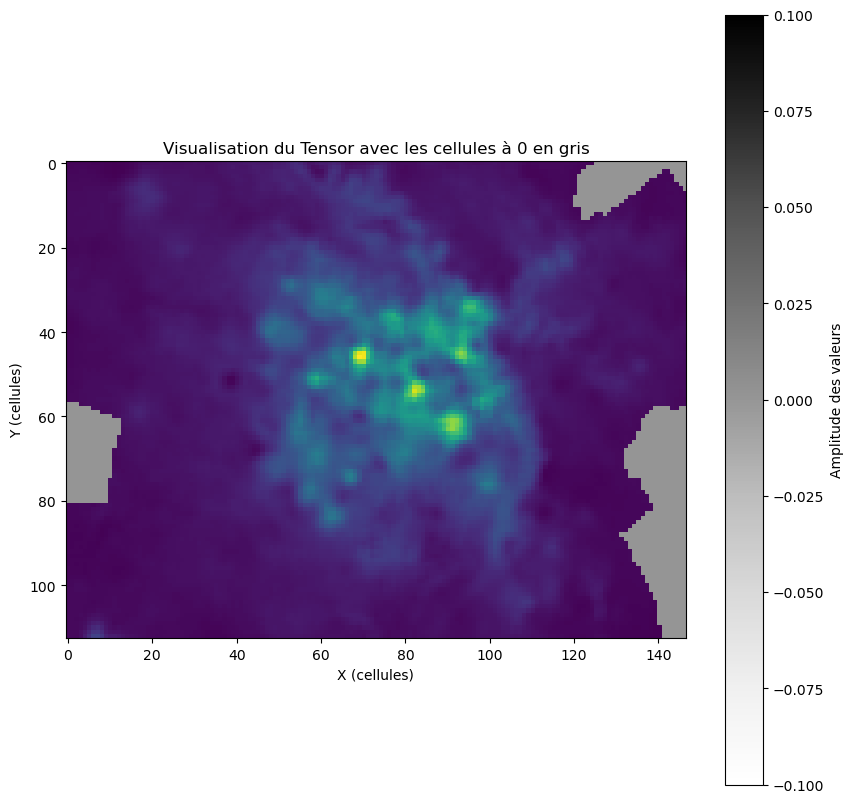

In [7]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt 
# Créer une figure et un axe
plt.figure(figsize=(10, 10))

# Afficher les cellules non nulles avec la colormap viridis
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=netmob[netmob > 0].min().item(), vmax=netmob.max().item())

# Afficher les cellules avec des valeurs non-nulles
plt.imshow(np.ma.masked_where(netmob == 0, netmob), cmap=cmap, norm=norm, origin='upper', interpolation='none')

# Afficher les cellules contenant 0 en gris
plt.imshow(np.ma.masked_where(netmob != 0, netmob), cmap=plt.cm.Greys, origin='upper', interpolation='none')

# Ajouter une barre de couleurs pour les cellules non nulles
plt.colorbar(label='Amplitude des valeurs')

# Ajouter un titre et des labels
plt.title('Visualisation du Tensor avec les cellules à 0 en gris')
plt.xlabel('X (cellules)')
plt.ylabel('Y (cellules)')

# Afficher le graphique
plt.show()